In [1]:
import copy
from datetime import datetime
from joblib import Parallel, delayed
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation
import numpy as np
import pandas as pd
import random
from scipy.signal import resample
from sdtw import SoftDTW
from sdtw.distance import SquaredEuclidean

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

In [3]:
from truth import IeeeGroundTruth
from wavelet import apply_wavelet
from peaks import get_peaks_v2
from signal_pross import (
    normalize_signal,
    detrend_w_poly,
    normalize_amplitude_to_1,
    n_moving_avg,
    min_max_scale,
    bandpass,
    get_hr
)

In [4]:
truths = []
for subject in range(1, 8):

    truth = IeeeGroundTruth(subject, 1, directory = 'channel_data3')
    truth.align_rgb_bvp()
    truth.fill_nans()
    truth.process_rgb()
    truth.process_bvp()

    truths.append(truth)

In [5]:
class LossFactory:

    def __init__(self, split_size, loss_type = 'mse', gamma = 1.0, mse_weight = None, dtw_weight = None):
        
        if loss_type not in ['mse', 'dtw', 'combined']:
            raise ValueError(f'Loss type [{loss_type}] not supported')
        
        self.split_size = split_size
        self.gamma = gamma
        self.mse_weight = mse_weight
        self.dtw_weight = dtw_weight

        if loss_type == 'mse':
            self.loss_function = self.mse_loss
        elif loss_type == 'dtw':
            self.loss_function = self.soft_dtw_loss
        elif loss_type == 'combined':
            self.loss_function = self.combined_loss
        
    def __call__(self, y_pred, data):
        return self.loss_function(y_pred, data)

    def mse_loss(self, y_pred, data):
        
        y_true = data.get_label()
        num_batches = int(len(y_pred) / self.split_size)
        errs = np.zeros_like(y_true)

        for i in range(num_batches):

            y_true_curr = y_true[i * self.split_size: (i + 1) * self.split_size]
            y_pred_curr = y_pred[i * self.split_size: (i + 1) * self.split_size]
            
            err = y_true_curr - y_pred_curr
            errs[i * self.split_size: (i + 1) * self.split_size] = err

        grad = -2 * errs
        hess = 2 * np.ones_like(y_true)
        return grad, hess

    def soft_dtw_loss(self, y_pred, data):

        y_true = data.get_label()
        num_batches = int(len(y_pred) / self.split_size)
        grads = np.zeros_like(y_true)
        hesses = np.zeros_like(y_true)

        for i in range(num_batches):

            y_true_curr = y_true[i * self.split_size: (i + 1) * self.split_size]
            y_pred_curr = y_pred[i * self.split_size: (i + 1) * self.split_size]
            
            grad_curr, hess_curr = self.soft_dtw_loss_helper(y_true_curr, y_pred_curr)
            grad_curr = grad_curr.flatten()
            hess_curr = hess_curr.flatten()

            grads[i * self.split_size: (i + 1) * self.split_size] = grad_curr
            hesses[i * self.split_size: (i + 1) * self.split_size] = hess_curr

        return grads, hesses
    
    def soft_dtw_loss_helper(self, y_true, y_pred):
        x = y_true.reshape(-1, 1)
        y = y_pred.reshape(-1, 1)
        D = SquaredEuclidean(x, y)
        sdtw = SoftDTW(D, gamma = self.gamma)
        sdtw.compute()
        E = sdtw.grad()
        G = D.jacobian_product(E)
        return G, np.ones(len(G))
    
    def combined_loss(self, y_pred, data):

        if self.mse_weight is None or self.dtw_weight is None:
            raise ValueError('mse_weight and dtw_weight must be set before calling combined_loss')

        mse_grads, mse_hesses = self.mse_loss(y_pred, data)
        dtw_grads, dtw_hesses = self.soft_dtw_loss(y_pred, data)

        combined_grad = self.mse_weight * mse_grads + self.dtw_weight * dtw_grads
        combined_hess = self.mse_weight * mse_hesses + self.dtw_weight * dtw_hesses

        return combined_grad, combined_hess

In [41]:
class LonePineGBM:
    
    def __init__(self, truths, label_col = 'bvp', subject_col = 'subject',
                # model customization
                model_type = 'gbdt', random_state = None, loss_type = 'mse', excluded_subject = None,
                # hyperparameters
                n_estimators = 100, split_size = 1280, learning_rate = 0.1, test_size = 0.3, early_stopping_rounds = 50,
                mse_weight = None, dtw_weight = None, data_beg = 1000, data_end = 10000, batches = 1, finetune = False,
                min_bandpass_freq = 0.67, max_bandpass_freq = 3.0, bandpass_order = 4,
                predicted_peaks_prominence = 0.22, true_peaks_prominence = 0.15,
                # hyperparams from LightGBM docs
                max_depth = 7, num_leaves = 75, max_bin = 255):
        
        if model_type not in ['gbdt', 'rf']:
            raise ValueError(f'Model type [{model_type}] not supported')
        
        self.label_col = label_col
        self.subject_col = subject_col

        self.model_type = model_type
        self.random_state = random_state
        self.excluded_subject = excluded_subject

        self.n_estimators = n_estimators
        self.split_size = split_size
        self.learning_rate = learning_rate
        self.test_size = test_size
        self.early_stopping_rounds = early_stopping_rounds

        self.data_beg = data_beg
        self.data_end = data_end
        self.finetune = finetune

        self.min_bandpass_freq = min_bandpass_freq
        self.max_bandpass_freq = max_bandpass_freq
        self.bandpass_order = bandpass_order
        self.predicted_peaks_prominence = predicted_peaks_prominence
        self.true_peaks_prominence = true_peaks_prominence

        self.max_depth = max_depth
        self.num_leaves = num_leaves
        self.max_bin = max_bin

        self.gbm = None
        self.training_loss = None
        self.test_loss = None

        self.given_data = self.prepare_dataset_from_subjects(truths, data_beg = data_beg, data_end = data_end)
        self.features = list(self.given_data.drop(columns = [self.label_col, self.subject_col]).columns)
        if self.excluded_subject is not None:
            self.given_data = self.given_data[self.given_data[self.subject_col] != self.excluded_subject]

        if self.random_state is not None:
            random.seed(self.random_state)
        splits = self.split_data()
        self.train_split_indices = random.sample(range(len(splits)), int(len(splits) * (1 - self.test_size)))
        self.train_splits = [splits[i] for i in self.train_split_indices]
        self.test_splits = [splits[i] for i in range(len(splits)) if i not in self.train_split_indices]
        
        self.train_data = []
        batch_size = len(self.train_splits) // batches
        print(f'Rows per batch: {batch_size * self.split_size}')
        for batch_num in range(batches):
            batch_split_idxs = random.sample(range(len(self.train_splits)), batch_size)
            batch_splits = [self.train_splits[i] for i in batch_split_idxs]
            self.train_splits = [self.train_splits[i] for i in range(len(self.train_splits)) if i not in batch_split_idxs]

            train_indices = [idx for split in batch_splits for idx in split]
            training_rows = self.given_data.iloc[train_indices].drop(columns = [self.subject_col])
            train_X = training_rows.drop(columns = [self.label_col]).to_numpy()
            train_y = training_rows[self.label_col].to_numpy()

            batch_data = lgb.Dataset(train_X, train_y, free_raw_data = False)
            self.train_data.append(batch_data)

        test_indices = [idx for split in self.test_splits for idx in split]
        test_rows = self.given_data.iloc[test_indices].drop(columns = [self.subject_col])
        test_X = test_rows.drop(columns = [self.label_col]).to_numpy()
        test_y = test_rows[self.label_col].to_numpy()
        self.test_data = lgb.Dataset(test_X, test_y, free_raw_data = False)

        self.loss = LossFactory(self.split_size, loss_type = loss_type, mse_weight = mse_weight, dtw_weight = dtw_weight)
    
    def split_data(self, to_exclude = None):
        
        data_in_use = self.given_data if to_exclude is None else self.given_data[~self.given_data[self.subject_col].isin(to_exclude)]

        subject_indices = data_in_use.groupby(self.subject_col).indices
        splits = []
        for _, indices in subject_indices.items():
            
            n_splits = len(indices) // self.split_size
            if n_splits > 0:

                subject_splits = []
                for i in range(n_splits):
                    split_start = i * self.split_size
                    split_end = (i + 1) * self.split_size
                    subject_split = indices[split_start: split_end]
                    subject_splits.append(subject_split)
                
                splits.extend(subject_splits)
        
        return splits

    def fit(self):
        t1 = datetime.today()
        
        params = {
            'metric': 'None',
            'verbosity': -1,
            'learning_rate': self.learning_rate,
            'objective': 'regression',
            'boosting': self.model_type,
            'max_depth': self.max_depth,
            'num_leaves': self.num_leaves,
            'max_bin': self.max_bin,
        }
    
        if self.model_type == 'rf':
            params['bagging_freq'] = 1
            params['bagging_fraction'] = 0.8


        training_loss_key = 'hr_err'
        feval = self.hr_error_eval_metric
        
        training_meta = {}

        for train_data in self.train_data:
            
            if self.model_type == 'gbdt':
                self.gbm = lgb.train(
                    params,
                    train_data,
                    valid_sets = [train_data, self.test_data],
                    valid_names=['train', 'test'],
                    fobj = self.loss,
                    num_boost_round = self.n_estimators,
                    feval=feval,
                    callbacks=[
                        early_stopping(stopping_rounds = self.early_stopping_rounds),
                        log_evaluation(period=5)
                    ],
                    evals_result = training_meta,
                    init_model = self.gbm
                )
            else:
                self.gbm = lgb.train(
                    params,
                    train_data,
                    valid_sets = [train_data, self.test_data],
                    valid_names=['train', 'test'],
                    num_boost_round = self.n_estimators,
                    feval=feval,
                    callbacks=[
                        early_stopping(stopping_rounds = self.early_stopping_rounds),
                        log_evaluation(period=5)
                    ],
                    evals_result = training_meta,
                )

            mse, hr_err, hr_err_sq = self.eval()
            print(f'Before fine-tuning: MSE = {mse}, HR error = {hr_err}, HR error (squared) = {hr_err_sq}')

            if self.model_type == 'gbdt' and self.finetune:
                
                print('\n\nFine-tuning...')
                gbm_copy = copy.deepcopy(self.gbm)
                pred = gbm_copy.predict(train_data.get_data())
                
                # new_targ = train_data.get_label() - pred
                new_targ = np.ones(len(pred))
                nsplits = len(pred) // self.split_size
                labels = train_data.get_label()
                for i in range(nsplits):
                    pred_curr = pred[i * self.split_size: (i + 1) * self.split_size]
                    label_curr = labels[i * self.split_size: (i + 1) * self.split_size]
                    hr_err = self.get_hr_error(pred_curr, label_curr, square = True)
                    new_targ[i * self.split_size: (i + 1) * self.split_size] = hr_err
                
                new_train_data = lgb.Dataset(train_data.get_data(), label = new_targ)

                self.gbm = lgb.train(
                    params,
                    new_train_data,
                    valid_sets = [new_train_data, self.test_data],
                    valid_names=['train', 'test'],
                    fobj = self.loss,
                    num_boost_round = self.n_estimators // 2,
                    feval=feval,
                    callbacks=[
                        early_stopping(stopping_rounds = self.early_stopping_rounds // 2),
                        log_evaluation(period=5)
                    ],
                    evals_result = training_meta,
                    init_model = gbm_copy
                )

            

        self.training_loss = training_meta['train'][training_loss_key]
        self.test_loss = training_meta['test'][training_loss_key]
        print(f'Finished training in {datetime.today() - t1}')

    def predict(self, X):
        return self.gbm.predict(X)

    def eval(self):
        
        test_X = self.test_data.get_data()
        test_y = self.test_data.get_label()
        nsplits = int(len(test_X) / self.split_size)
        errs = []
        mses = np.zeros(len(test_X))
        
        for i in range(nsplits):

            curr_pred = self.predict(test_X[i * self.split_size: (i + 1) * self.split_size, :])
            curr_true = test_y[i * self.split_size: (i + 1) * self.split_size]
            curr_true, curr_pred = self.process_signal(curr_true, curr_pred, smoothing_window = 5, use_bandpass = True)
            
            mses[i * self.split_size: (i + 1) * self.split_size] = curr_true - curr_pred
            hr_err = self.get_hr_error(curr_true, curr_pred, square = False)
            errs.append(hr_err)
        
        return np.mean(np.square(mses)), np.mean(errs), np.mean(np.square(errs))

    def plot_loss(self):
        if self.training_loss is not None and self.test_loss is not None:
            training_loss_normed = min_max_scale(self.training_loss)
            test_loss_normed = min_max_scale(self.test_loss)
            plt.plot(training_loss_normed, label = 'training loss')
            plt.plot(test_loss_normed, label = 'test loss')
            plt.legend()
        
    def get_model_stats(self):

        model_info = self.gbm.dump_model()
        tree_depths = []

        for tree_info in model_info['tree_info']:
            tree_structure = tree_info['tree_structure']
            
            # Recursive function to compute the depth of a tree
            def calculate_depth(node, current_depth=0):
                if 'leaf_value' in node:
                    return current_depth
                else:
                    left_depth = calculate_depth(node['left_child'], current_depth + 1)
                    right_depth = calculate_depth(node['right_child'], current_depth + 1)
                    return max(left_depth, right_depth)

            tree_depth = calculate_depth(tree_structure)
            tree_depths.append(tree_depth)
        

        print(f'Best test loss: {min(self.test_loss)}\n')
        print('Tree depth stats:')
        print('Min tree depth:', min(tree_depths))
        print('Max tree depth:', max(tree_depths))
        print('Avg tree depth:', np.mean(tree_depths))
        print('\nFeature importances:')
        display(self.get_feature_importances())
    
    def get_feature_importances(self):
        importances = self.gbm.feature_importance(importance_type='gain')
        feature_importances = pd.DataFrame({'feature': self.features, 'importance': importances})
        feature_importances = feature_importances.sort_values('importance', ascending=False)
        return feature_importances
    
    def hr_error_eval_metric(self, y_pred, eval_data):
        y_true = eval_data.get_label()
        nsplits = int(len(y_pred) / self.split_size)
        hr_err = []
        for i in range(nsplits):
            curr_pred = y_pred[i * self.split_size: (i + 1) * self.split_size]
            curr_true = y_true[i * self.split_size: (i + 1) * self.split_size]
            curr_true, curr_pred = self.process_signal(curr_true, curr_pred, smoothing_window = 10, use_bandpass = True)
            hr_err.append(self.get_hr_error(curr_true, curr_pred, square = False))
        return 'hr_err', np.mean(hr_err), False
    
    def get_hr_error(self, y_true, y_pred, square = True):

        true_peaks, _ = self.get_true_peaks(y_true)
        pred_peaks, _ = self.get_predicted_peaks(y_pred)

        if len(true_peaks) >= 2:
            true_ibis = np.diff(true_peaks) / 64
            true_hr = 60 / np.mean(true_ibis)
        else:
            true_hr = 0

        if len(pred_peaks) >= 2:
            pred_ibis = np.diff(pred_peaks) / 64
            pred_hr = 60 / np.mean(pred_ibis)
        else:
            pred_hr = 0
        
        if square:
            return np.power(true_hr - pred_hr, 2)
        return abs(true_hr - pred_hr)
    
    def process_signal(self, y_true, y_pred, smoothing_window = 10, use_bandpass = False):
    
        orig_len = len(y_pred)
        y_pred = n_moving_avg(y_pred, smoothing_window)
        y_pred = resample(y_pred, orig_len)
        if use_bandpass:
            y_pred = bandpass(y_pred, 64, [self.min_bandpass_freq, self.max_bandpass_freq], self.bandpass_order)
        y_pred = min_max_scale(y_pred)
        
        y_true = n_moving_avg(y_true, 20)
        y_true = resample(y_true, orig_len)
        if use_bandpass:
            y_true = bandpass(y_true, 64, [self.min_bandpass_freq, self.max_bandpass_freq], self.bandpass_order)
        y_true = min_max_scale(y_true)
        
        return y_true, y_pred
    
    def get_predicted_peaks(self, signal):
        return get_peaks_v2(signal, 64, 3.0, -1, prominence = self.predicted_peaks_prominence, with_min_dist = True, with_valleys = False)
    def get_true_peaks(self, signal):
        return get_peaks_v2(signal, 64, 3.0, -1, prominence = self.true_peaks_prominence, with_min_dist = True, with_valleys = False)

    @staticmethod
    def prepare_dataset_from_subjects(truths, data_beg = 1000, data_end = 2000):
        data_arr = []
        for i in range(len(truths)):    
            truth = truths[i]
            data = truth.prepare_data_for_ml()
            data = data.iloc[data_beg: data_end, :]
            data['subject'] = i + 1
            data_arr.append(data)
        return pd.concat(data_arr)


In [73]:
def subjectwise_kfold(truths, model_type = 'gbdt', random_state = None, loss_type = 'mse',
                    n_estimators = 100, split_size = 1280, learning_rate = 0.1, test_size = 0.3, early_stopping_rounds = 50,
                    mse_weight = None, dtw_weight = None, data_beg = 1000, data_end = 10000, batches = 1, finetune = False, rounds_per_model = 1):
        
        models = {}
        for subj_idx in range(len(truths)):
            models[subj_idx + 1] = []
            for i in range(rounds_per_model):
                
                print(f'\n\nTraining excluding subject {subj_idx + 1}...\n')
                mod = LonePineGBM(
                    truths = truths,
                    model_type = model_type,
                    random_state = random_state,
                    loss_type = loss_type,
                    n_estimators = n_estimators,
                    split_size = split_size,
                    learning_rate = learning_rate,
                    test_size = test_size,
                    early_stopping_rounds = early_stopping_rounds,
                    mse_weight = mse_weight,
                    dtw_weight = dtw_weight,
                    data_beg = data_beg,
                    data_end = data_end,
                    batches = batches,
                    finetune = finetune,
                    excluded_subject = subj_idx + 1
                )
                mod.fit()
                models[subj_idx + 1].append(mod)
        
        model_performances = {}
        for subj_idx in models:
            model_performances[subj_idx] = []
            for i in range(rounds_per_model):
                mod = models[subj_idx][i]
                model_performances[subj_idx].append(mod.eval())
        
        print(f'Mean HR Performance: {np.mean([model_performances[subj_idx][i][1] for subj_idx in model_performances for i in range(rounds_per_model)])}')
        return models, model_performances

In [74]:
models, model_performances = subjectwise_kfold(
    truths, model_type = 'gbdt', random_state = None, loss_type = 'combined',
    n_estimators = 100, split_size = 1280, learning_rate = 0.1, test_size = 0.3, 
    early_stopping_rounds = 50, mse_weight = 0.25, dtw_weight = 0.75, 
    data_beg = 3000, data_end = 5000, batches = 1, finetune = False, rounds_per_model = 3
)



Training excluding subject 1...

Rows per batch: 3840


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[5]	train's hr_err: 13.794	test's hr_err: 8.5425
[10]	train's hr_err: 12.1261	test's hr_err: 16.6253
[15]	train's hr_err: 14.825	test's hr_err: 17.6297
[20]	train's hr_err: 13.2214	test's hr_err: 17.3416
[25]	train's hr_err: 10.4326	test's hr_err: 10.3016
[30]	train's hr_err: 12.6386	test's hr_err: 4.6709
[35]	train's hr_err: 12.4706	test's hr_err: 15.2508
[40]	train's hr_err: 35.8622	test's hr_err: 18.9077
[45]	train's hr_err: 34.9011	test's hr_err: 24.3658
[50]	train's hr_err: 37.0081	test's hr_err: 21.3126
[55]	train's hr_err: 31.3777	test's hr_err: 24.1053
[60]	train's hr_err: 29.6558	test's hr_err: 17.9344
[65]	train's hr_err: 33.8893	test's hr_err: 21.9145
[70]	train's hr_err: 37.7082	test's hr_err: 16.2491
[75]	train's hr_err: 37.7261	test's hr_err: 25.9535
[80]	train's hr_err: 39.0606	test's hr_err: 33.4679
Early stopping, best iteration is:
[31]	train's hr_err: 9.74651	test's hr_err: 2.47841
Before fine-tuning: MSE =

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[5]	train's hr_err: 2.171	test's hr_err: 25.7821
[10]	train's hr_err: 7.03051	test's hr_err: 27.3203
[15]	train's hr_err: 12.2775	test's hr_err: 23.9772
[20]	train's hr_err: 12.0469	test's hr_err: 27.654
[25]	train's hr_err: 13.5594	test's hr_err: 20.6697
[30]	train's hr_err: 23.2487	test's hr_err: 11.7232
[35]	train's hr_err: 35.8769	test's hr_err: 36.5999
[40]	train's hr_err: 30.1929	test's hr_err: 22.4551
[45]	train's hr_err: 20.0942	test's hr_err: 14.0122
[50]	train's hr_err: 27.2208	test's hr_err: 4.4151
[55]	train's hr_err: 39.1229	test's hr_err: 12.7228
[60]	train's hr_err: 30.6388	test's hr_err: 18.4844
[65]	train's hr_err: 22.9521	test's hr_err: 18.9018
[70]	train's hr_err: 25.834	test's hr_err: 11.8268
[75]	train's hr_err: 20.3791	test's hr_err: 11.856
[80]	train's hr_err: 20.9978	test's hr_err: 6.64672
[85]	train's hr_err: 21.3782	test's hr_err: 9.76867
[90]	train's hr_err: 21.3782	test's hr_err: 11.5907
[95]	train

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[5]	train's hr_err: 10.8024	test's hr_err: 6.27983
[10]	train's hr_err: 9.71111	test's hr_err: 5.60173
[15]	train's hr_err: 12.3447	test's hr_err: 5.36847
[20]	train's hr_err: 18.061	test's hr_err: 5.18373
[25]	train's hr_err: 25.5525	test's hr_err: 5.11011
[30]	train's hr_err: 21.0653	test's hr_err: 6.70444
[35]	train's hr_err: 34.8987	test's hr_err: 9.40032
[40]	train's hr_err: 38.1544	test's hr_err: 8.73774
[45]	train's hr_err: 34.6649	test's hr_err: 11.3192
[50]	train's hr_err: 33.9239	test's hr_err: 7.11749
[55]	train's hr_err: 32.4921	test's hr_err: 12.0226
[60]	train's hr_err: 29.2563	test's hr_err: 10.3791
[65]	train's hr_err: 28.043	test's hr_err: 10.3791
[70]	train's hr_err: 29.0899	test's hr_err: 12.0007
Early stopping, best iteration is:
[22]	train's hr_err: 21.9108	test's hr_err: 3.55711
Before fine-tuning: MSE = 0.0872646219644698, HR error = 2.067557282534384, HR error (squared) = 7.183119193275275
Finished tra

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[5]	train's hr_err: 15.2515	test's hr_err: 3.6217
[10]	train's hr_err: 17.9744	test's hr_err: 9.61545
[15]	train's hr_err: 13.1531	test's hr_err: 19.3883
[20]	train's hr_err: 17.9741	test's hr_err: 19.3763
[25]	train's hr_err: 24.4175	test's hr_err: 12.9571
[30]	train's hr_err: 30.33	test's hr_err: 14.4405
[35]	train's hr_err: 37.3213	test's hr_err: 11.587
[40]	train's hr_err: 34.8928	test's hr_err: 11.587
[45]	train's hr_err: 34.7848	test's hr_err: 18.5532
[50]	train's hr_err: 29.1814	test's hr_err: 23.2198
Early stopping, best iteration is:
[3]	train's hr_err: 14.6251	test's hr_err: 2.17586
Before fine-tuning: MSE = 0.08513277825786403, HR error = 1.8676461573885135, HR error (squared) = 3.552509734662198
Finished training in 0:00:37.633629


Training excluding subject 2...

Rows per batch: 3840


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[5]	train's hr_err: 12.775	test's hr_err: 7.19982
[10]	train's hr_err: 12.3718	test's hr_err: 12.8462
[15]	train's hr_err: 17.3665	test's hr_err: 6.39223
[20]	train's hr_err: 23.6401	test's hr_err: 17.309
[25]	train's hr_err: 26.9774	test's hr_err: 15.5902
[30]	train's hr_err: 37.235	test's hr_err: 9.1476
[35]	train's hr_err: 36.3909	test's hr_err: 13.8735
[40]	train's hr_err: 39.7694	test's hr_err: 6.81026
[45]	train's hr_err: 34.3164	test's hr_err: 3.38845
[50]	train's hr_err: 35.3716	test's hr_err: 2.57266
[55]	train's hr_err: 35.7081	test's hr_err: 3.78793
[60]	train's hr_err: 34.6468	test's hr_err: 5.74114
[65]	train's hr_err: 36.7554	test's hr_err: 5.77269
[70]	train's hr_err: 36.7881	test's hr_err: 5.77269
[75]	train's hr_err: 36.7731	test's hr_err: 5.8571
[80]	train's hr_err: 36.7731	test's hr_err: 5.8571
[85]	train's hr_err: 36.7731	test's hr_err: 5.8571
[90]	train's hr_err: 36.7731	test's hr_err: 5.8571
[95]	train's

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[5]	train's hr_err: 28.903	test's hr_err: 32.4459
[10]	train's hr_err: 27.7226	test's hr_err: 28.4429
[15]	train's hr_err: 29.3133	test's hr_err: 30.3174
[20]	train's hr_err: 36.6724	test's hr_err: 26.5417
[25]	train's hr_err: 38.9435	test's hr_err: 26.5106
[30]	train's hr_err: 34.3787	test's hr_err: 19.9408
[35]	train's hr_err: 36.2775	test's hr_err: 24.4374
[40]	train's hr_err: 36.2494	test's hr_err: 17.5117
[45]	train's hr_err: 30.4316	test's hr_err: 20.7899
[50]	train's hr_err: 30.3582	test's hr_err: 22.3247
[55]	train's hr_err: 28.3203	test's hr_err: 18.3387
[60]	train's hr_err: 29.0885	test's hr_err: 18.3008
[65]	train's hr_err: 26.236	test's hr_err: 18.3008
[70]	train's hr_err: 26.5448	test's hr_err: 18.2734
[75]	train's hr_err: 26.548	test's hr_err: 18.2734
[80]	train's hr_err: 26.5512	test's hr_err: 18.3114
[85]	train's hr_err: 26.5512	test's hr_err: 18.3114
[90]	train's hr_err: 26.5669	test's hr_err: 18.3114
Early s

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[5]	train's hr_err: 24.923	test's hr_err: 19.5676
[10]	train's hr_err: 12.8151	test's hr_err: 4.70311
[15]	train's hr_err: 10.2063	test's hr_err: 6.77964
[20]	train's hr_err: 18.9367	test's hr_err: 13.0281
[25]	train's hr_err: 25.5996	test's hr_err: 12.6246
[30]	train's hr_err: 28.7679	test's hr_err: 13.3776
[35]	train's hr_err: 30.9219	test's hr_err: 17.9172
[40]	train's hr_err: 32.0621	test's hr_err: 16.7114
[45]	train's hr_err: 32.9968	test's hr_err: 17.2901
[50]	train's hr_err: 29.285	test's hr_err: 27.4771
[55]	train's hr_err: 30.7065	test's hr_err: 26.2928
[60]	train's hr_err: 30.7006	test's hr_err: 26.2928
[65]	train's hr_err: 29.6793	test's hr_err: 29.7678
Early stopping, best iteration is:
[16]	train's hr_err: 13.4178	test's hr_err: 2.45529
Before fine-tuning: MSE = 0.09624723183383373, HR error = 4.431206958116967, HR error (squared) = 20.47042146881852
Finished training in 0:00:44.813362


Training excluding subjec

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[5]	train's hr_err: 18.4496	test's hr_err: 8.21397
[10]	train's hr_err: 16.201	test's hr_err: 8.33671
[15]	train's hr_err: 14.267	test's hr_err: 3.40532
[20]	train's hr_err: 15.3169	test's hr_err: 9.94476
[25]	train's hr_err: 21.2368	test's hr_err: 16.1926
[30]	train's hr_err: 29.9559	test's hr_err: 21.7428
[35]	train's hr_err: 31.4178	test's hr_err: 22.453
[40]	train's hr_err: 38.8879	test's hr_err: 17.9904
[45]	train's hr_err: 40.5769	test's hr_err: 24.0156
[50]	train's hr_err: 40.4108	test's hr_err: 22.0306
[55]	train's hr_err: 36.0844	test's hr_err: 22.4964
[60]	train's hr_err: 34.21	test's hr_err: 22.7992
Early stopping, best iteration is:
[13]	train's hr_err: 14.3092	test's hr_err: 1.71272
Before fine-tuning: MSE = 0.09763577813074895, HR error = 5.171930407177378, HR error (squared) = 36.76680560486031
Finished training in 0:00:45.385880


Training excluding subject 3...

Rows per batch: 3840


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[5]	train's hr_err: 20.2937	test's hr_err: 19.7346
[10]	train's hr_err: 17.9068	test's hr_err: 20.8665
[15]	train's hr_err: 18.35	test's hr_err: 21.9216
[20]	train's hr_err: 25.1838	test's hr_err: 25.0816
[25]	train's hr_err: 29.3823	test's hr_err: 23.6188
[30]	train's hr_err: 31.1701	test's hr_err: 24.6112
[35]	train's hr_err: 28.2772	test's hr_err: 21.4287
[40]	train's hr_err: 30.9381	test's hr_err: 19.8646
[45]	train's hr_err: 26.5741	test's hr_err: 24.766
[50]	train's hr_err: 28.6694	test's hr_err: 24.1589
[55]	train's hr_err: 25.521	test's hr_err: 23.1797
[60]	train's hr_err: 24.4462	test's hr_err: 21.2673
Early stopping, best iteration is:
[13]	train's hr_err: 12.3446	test's hr_err: 18.6008
Before fine-tuning: MSE = 0.11613334501373469, HR error = 20.3738610256188, HR error (squared) = 439.11122300936796
Finished training in 0:00:44.226027


Training excluding subject 4...

Rows per batch: 5120


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[5]	train's hr_err: 14.9454	test's hr_err: 15.3703
[10]	train's hr_err: 12.0364	test's hr_err: 15.3398
[15]	train's hr_err: 8.40672	test's hr_err: 10.3385
[20]	train's hr_err: 22.0036	test's hr_err: 16.296
[25]	train's hr_err: 22.6556	test's hr_err: 18.8462
[30]	train's hr_err: 24.9588	test's hr_err: 13.1999
[35]	train's hr_err: 38.7885	test's hr_err: 13.8668
[40]	train's hr_err: 36.5062	test's hr_err: 9.76281
[45]	train's hr_err: 31.9253	test's hr_err: 15.7648
[50]	train's hr_err: 35.4145	test's hr_err: 17.4012
[55]	train's hr_err: 29.9155	test's hr_err: 19.5336
[60]	train's hr_err: 28.216	test's hr_err: 17.7067
[65]	train's hr_err: 25.8122	test's hr_err: 17.7067
[70]	train's hr_err: 22.8855	test's hr_err: 10.7023
[75]	train's hr_err: 24.5706	test's hr_err: 10.7023
[80]	train's hr_err: 25.7798	test's hr_err: 10.7023
[85]	train's hr_err: 24.6617	test's hr_err: 10.7697
[90]	train's hr_err: 24.6617	test's hr_err: 10.7697
Early 

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[5]	train's hr_err: 16.6082	test's hr_err: 9.12351
[10]	train's hr_err: 9.85755	test's hr_err: 10.0472
[15]	train's hr_err: 17.8032	test's hr_err: 6.15192
[20]	train's hr_err: 23.8115	test's hr_err: 9.47276
[25]	train's hr_err: 28.1095	test's hr_err: 3.87001
[30]	train's hr_err: 32.2751	test's hr_err: 5.27901
[35]	train's hr_err: 39.9935	test's hr_err: 10.2965
[40]	train's hr_err: 39.025	test's hr_err: 10.274
[45]	train's hr_err: 35.3594	test's hr_err: 13.704
[50]	train's hr_err: 38.0402	test's hr_err: 8.70473
[55]	train's hr_err: 39.1191	test's hr_err: 7.03006
[60]	train's hr_err: 39.2101	test's hr_err: 7.0803
[65]	train's hr_err: 39.8817	test's hr_err: 9.88649
[70]	train's hr_err: 39.0874	test's hr_err: 9.90938
[75]	train's hr_err: 37.4967	test's hr_err: 11.4961
Early stopping, best iteration is:
[26]	train's hr_err: 28.1364	test's hr_err: 2.24559
Before fine-tuning: MSE = 0.0788152242380856, HR error = 3.900475985213788, H

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[5]	train's hr_err: 18.1541	test's hr_err: 3.93223
[10]	train's hr_err: 15.3611	test's hr_err: 11.2804
[15]	train's hr_err: 18.0953	test's hr_err: 13.2572
[20]	train's hr_err: 27.226	test's hr_err: 12.1568
[25]	train's hr_err: 31.6021	test's hr_err: 16.1764
[30]	train's hr_err: 41.287	test's hr_err: 7.71307
[35]	train's hr_err: 39.1037	test's hr_err: 2.8747
[40]	train's hr_err: 38.1499	test's hr_err: 12.9221
[45]	train's hr_err: 38.114	test's hr_err: 6.34486
[50]	train's hr_err: 39.4993	test's hr_err: 8.92002
[55]	train's hr_err: 39.525	test's hr_err: 12.6735
Early stopping, best iteration is:
[7]	train's hr_err: 18.9468	test's hr_err: 1.88201
Before fine-tuning: MSE = 0.1144535515636335, HR error = 8.42784504443048, HR error (squared) = 86.8726936187627
Finished training in 0:00:50.814065


Training excluding subject 5...

Rows per batch: 3840


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[5]	train's hr_err: 25.7081	test's hr_err: 5.76233
[10]	train's hr_err: 28.7952	test's hr_err: 19.9529
[15]	train's hr_err: 23.0539	test's hr_err: 10.8461
[20]	train's hr_err: 27.1516	test's hr_err: 8.28054
[25]	train's hr_err: 40.638	test's hr_err: 9.56447
[30]	train's hr_err: 39.5415	test's hr_err: 8.28863
[35]	train's hr_err: 43.9321	test's hr_err: 12.0041
[40]	train's hr_err: 41.5879	test's hr_err: 10.4398
[45]	train's hr_err: 39.1554	test's hr_err: 7.09473
[50]	train's hr_err: 35.5218	test's hr_err: 5.0346
[55]	train's hr_err: 35.486	test's hr_err: 4.59601
[60]	train's hr_err: 35.486	test's hr_err: 4.59601
[65]	train's hr_err: 33.4097	test's hr_err: 6.2081
[70]	train's hr_err: 33.4033	test's hr_err: 6.18152
[75]	train's hr_err: 33.4033	test's hr_err: 6.18152
[80]	train's hr_err: 33.4033	test's hr_err: 6.56957
[85]	train's hr_err: 33.4033	test's hr_err: 6.54453
[90]	train's hr_err: 32.3549	test's hr_err: 6.15582
[95]	trai

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[5]	train's hr_err: 26.9881	test's hr_err: 7.34296
[10]	train's hr_err: 17.329	test's hr_err: 10.8812
[15]	train's hr_err: 9.50643	test's hr_err: 11.6129
[20]	train's hr_err: 15.4145	test's hr_err: 9.90352
[25]	train's hr_err: 23.2909	test's hr_err: 9.78622
[30]	train's hr_err: 21.2461	test's hr_err: 14.0758
[35]	train's hr_err: 25.8173	test's hr_err: 5.43014
[40]	train's hr_err: 34.3809	test's hr_err: 4.7048
[45]	train's hr_err: 33.3503	test's hr_err: 4.59924
[50]	train's hr_err: 32.1961	test's hr_err: 0.780608
[55]	train's hr_err: 31.8652	test's hr_err: 0.465121
[60]	train's hr_err: 31.0514	test's hr_err: 2.3704
[65]	train's hr_err: 29.0237	test's hr_err: 2.3704
[70]	train's hr_err: 26.9855	test's hr_err: 1.33407
[75]	train's hr_err: 29.2105	test's hr_err: 1.33407
[80]	train's hr_err: 29.2105	test's hr_err: 1.33407
[85]	train's hr_err: 29.2105	test's hr_err: 1.33407
[90]	train's hr_err: 29.2105	test's hr_err: 1.36304
[95]	t

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[5]	train's hr_err: 14.9506	test's hr_err: 8.70544
[10]	train's hr_err: 28.7167	test's hr_err: 7.00054
[15]	train's hr_err: 26.2845	test's hr_err: 7.71212
[20]	train's hr_err: 27.03	test's hr_err: 18.3497
[25]	train's hr_err: 35.1144	test's hr_err: 18.1038
[30]	train's hr_err: 33.6584	test's hr_err: 15.153
[35]	train's hr_err: 33.3056	test's hr_err: 19.819
[40]	train's hr_err: 27.0058	test's hr_err: 26.1414
[45]	train's hr_err: 23.2176	test's hr_err: 26.0457
[50]	train's hr_err: 20.3558	test's hr_err: 27.5997
[55]	train's hr_err: 18.8705	test's hr_err: 31.104
Early stopping, best iteration is:
[9]	train's hr_err: 28.6951	test's hr_err: 3.97178
Before fine-tuning: MSE = 0.08514799470069283, HR error = 5.596084860528116, HR error (squared) = 32.698749428166
Finished training in 0:00:43.111980


Training excluding subject 6...

Rows per batch: 3840


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[5]	train's hr_err: 22.3881	test's hr_err: 39.6687
[10]	train's hr_err: 20.1167	test's hr_err: 35.0122
[15]	train's hr_err: 9.63199	test's hr_err: 34.974
[20]	train's hr_err: 31.1131	test's hr_err: 27.0271
[25]	train's hr_err: 35.1453	test's hr_err: 12.7122
[30]	train's hr_err: 39.7958	test's hr_err: 13.6767
[35]	train's hr_err: 44.5251	test's hr_err: 16.0953
[40]	train's hr_err: 42.328	test's hr_err: 4.02552
[45]	train's hr_err: 35.1962	test's hr_err: 11.1385
[50]	train's hr_err: 30.6873	test's hr_err: 7.36617
[55]	train's hr_err: 28.3576	test's hr_err: 37.3545
[60]	train's hr_err: 38.933	test's hr_err: 41.6859
[65]	train's hr_err: 30.0078	test's hr_err: 46.1991
[70]	train's hr_err: 42.8511	test's hr_err: 33.033
[75]	train's hr_err: 50.0203	test's hr_err: 30.6253
[80]	train's hr_err: 50.1645	test's hr_err: 24.6598
[85]	train's hr_err: 61.105	test's hr_err: 18.296
[90]	train's hr_err: 64.6104	test's hr_err: 23.4038
Early stop

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[5]	train's hr_err: 4.00729	test's hr_err: 29.3283
[10]	train's hr_err: 6.23905	test's hr_err: 35.0482
[15]	train's hr_err: 7.31694	test's hr_err: 33.7753
[20]	train's hr_err: 12.4721	test's hr_err: 45.6647
[25]	train's hr_err: 18.88	test's hr_err: 47.644
[30]	train's hr_err: 22.2182	test's hr_err: 39.4239
[35]	train's hr_err: 28.4849	test's hr_err: 29.0484
[40]	train's hr_err: 34.931	test's hr_err: 25.9405
[45]	train's hr_err: 27.1087	test's hr_err: 34.1164
[50]	train's hr_err: 22.4177	test's hr_err: 45.0084
[55]	train's hr_err: 34.2337	test's hr_err: 46.1827
[60]	train's hr_err: 24.4606	test's hr_err: 45.1327
[65]	train's hr_err: 17.3772	test's hr_err: 49.8686
[70]	train's hr_err: 21.5056	test's hr_err: 47.9447
[75]	train's hr_err: 33.3372	test's hr_err: 51.9516
[80]	train's hr_err: 34.0547	test's hr_err: 47.9072
[85]	train's hr_err: 22.9921	test's hr_err: 58.3239
Early stopping, best iteration is:
[36]	train's hr_err: 29.7

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[5]	train's hr_err: 14.301	test's hr_err: 32.9933
[10]	train's hr_err: 17.4481	test's hr_err: 36.4594
[15]	train's hr_err: 17.4858	test's hr_err: 37.7219
[20]	train's hr_err: 24.6035	test's hr_err: 25.4099
[25]	train's hr_err: 25.4918	test's hr_err: 20.881
[30]	train's hr_err: 32.2321	test's hr_err: 13.3831
[35]	train's hr_err: 41.1402	test's hr_err: 7.60261
[40]	train's hr_err: 35.6152	test's hr_err: 6.75687
[45]	train's hr_err: 25.5022	test's hr_err: 19.803
[50]	train's hr_err: 30.795	test's hr_err: 25.3307
[55]	train's hr_err: 25.8533	test's hr_err: 26.2334
[60]	train's hr_err: 47.6454	test's hr_err: 36.4354
[65]	train's hr_err: 50.2734	test's hr_err: 36.1862
[70]	train's hr_err: 50.1879	test's hr_err: 28.7867
[75]	train's hr_err: 38.1025	test's hr_err: 29.9316
[80]	train's hr_err: 48.1061	test's hr_err: 21.0086
[85]	train's hr_err: 43.6983	test's hr_err: 25.0297
[90]	train's hr_err: 44.7892	test's hr_err: 24.8086
Early st

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[5]	train's hr_err: 13.9224	test's hr_err: 36.8562
[10]	train's hr_err: 14.7452	test's hr_err: 29.5457
[15]	train's hr_err: 9.46351	test's hr_err: 33.3989
[20]	train's hr_err: 11.429	test's hr_err: 27.8453
[25]	train's hr_err: 13.3861	test's hr_err: 32.2786
[30]	train's hr_err: 17.6416	test's hr_err: 37.7529
[35]	train's hr_err: 33.9092	test's hr_err: 38.7215
[40]	train's hr_err: 32.8604	test's hr_err: 34.0202
[45]	train's hr_err: 25.9229	test's hr_err: 40.2097
[50]	train's hr_err: 24.5679	test's hr_err: 34.0104
[55]	train's hr_err: 22.1161	test's hr_err: 34.1203
[60]	train's hr_err: 19.4	test's hr_err: 30.9983
[65]	train's hr_err: 19.3844	test's hr_err: 27.9286
[70]	train's hr_err: 18.4028	test's hr_err: 26.3864
[75]	train's hr_err: 17.2078	test's hr_err: 24.895
[80]	train's hr_err: 17.2078	test's hr_err: 23.3528
[85]	train's hr_err: 16.1438	test's hr_err: 25.9561
[90]	train's hr_err: 16.1438	test's hr_err: 25.9398
[95]	trai

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[5]	train's hr_err: 12.7672	test's hr_err: 21.5071
[10]	train's hr_err: 16.411	test's hr_err: 24.6361
[15]	train's hr_err: 18.5983	test's hr_err: 29.1123
[20]	train's hr_err: 25.0847	test's hr_err: 13.0627
[25]	train's hr_err: 28.1474	test's hr_err: 15.3254
[30]	train's hr_err: 23.6376	test's hr_err: 14.5446
[35]	train's hr_err: 42.5246	test's hr_err: 28.4528
[40]	train's hr_err: 40.5433	test's hr_err: 20.2672
[45]	train's hr_err: 23.05	test's hr_err: 19.3196
[50]	train's hr_err: 30.4809	test's hr_err: 18.7694
[55]	train's hr_err: 24.6013	test's hr_err: 62.2257
[60]	train's hr_err: 46.8491	test's hr_err: 39.0688
[65]	train's hr_err: 54.8106	test's hr_err: 30.822
[70]	train's hr_err: 60.4297	test's hr_err: 31.801
Early stopping, best iteration is:
[21]	train's hr_err: 25.4832	test's hr_err: 9.15567
Before fine-tuning: MSE = 0.0757708111849176, HR error = 11.794872921694811, HR error (squared) = 152.6911735330254
Finished train

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[5]	train's hr_err: 15.1692	test's hr_err: 4.80977
[10]	train's hr_err: 9.2992	test's hr_err: 14.1414
[15]	train's hr_err: 12.655	test's hr_err: 7.81599
[20]	train's hr_err: 16.1487	test's hr_err: 26.5076
[25]	train's hr_err: 25.864	test's hr_err: 22.2313
[30]	train's hr_err: 36.2806	test's hr_err: 14.2279
[35]	train's hr_err: 50.0048	test's hr_err: 17.2359
[40]	train's hr_err: 53.6173	test's hr_err: 28.6112
[45]	train's hr_err: 53.151	test's hr_err: 28.5157
[50]	train's hr_err: 48.7431	test's hr_err: 26.3314
[55]	train's hr_err: 46.7405	test's hr_err: 26.225
[60]	train's hr_err: 45.5181	test's hr_err: 27.88
Early stopping, best iteration is:
[13]	train's hr_err: 6.10213	test's hr_err: 3.15847
Before fine-tuning: MSE = 0.08801620723055074, HR error = 7.064032481396325, HR error (squared) = 68.78719350394684
Finished training in 0:01:06.858009
Mean HR Performance: 74.98458840889617


In [77]:
np.mean([model_performances[sub][i][1] for sub in model_performances for i in range(3)])

10.629125474814307

In [62]:
test_subject = 7
test_subject_truth = truths[test_subject - 1]

mod = LonePineGBM(
    truths, n_estimators = 100, loss_type = 'combined', split_size = 1280,
    excluded_subject = test_subject, model_type = 'gbdt', learning_rate = 0.005, early_stopping_rounds = 20,
    mse_weight = 0.25, dtw_weight = 0.75, batches = 4, finetune = True, data_beg = 2000, data_end = 5000
)
mod.fit()

Rows per batch: 1280


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 20 rounds
[5]	train's hr_err: 0.719492	test's hr_err: 17.4222
[10]	train's hr_err: 0.719492	test's hr_err: 17.3643
[15]	train's hr_err: 0.785552	test's hr_err: 14.8848
[20]	train's hr_err: 2.46459	test's hr_err: 13.4099
Early stopping, best iteration is:
[1]	train's hr_err: 2.54715	test's hr_err: 12.2647
Before fine-tuning: MSE = 0.06744931649626887, HR error = 15.19029706841403, HR error (squared) = 346.31847765165895


Fine-tuning...


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 10 rounds
[5]	train's hr_err: 76.3354	test's hr_err: 12.2466
[10]	train's hr_err: 76.3354	test's hr_err: 12.2466
[15]	train's hr_err: 76.3354	test's hr_err: 12.2466
Early stopping, best iteration is:
[5]	train's hr_err: 76.3354	test's hr_err: 12.2466


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 20 rounds
[10]	train's hr_err: 1.05573	test's hr_err: 30.3905
[15]	train's hr_err: 1.05573	test's hr_err: 30.3905
[20]	train's hr_err: 1.05573	test's hr_err: 30.3873
[25]	train's hr_err: 1.05573	test's hr_err: 26.5525
Early stopping, best iteration is:
[6]	train's hr_err: 0.966968	test's hr_err: 23.692
Before fine-tuning: MSE = 0.08767290207538889, HR error = 29.03928633707727, HR error (squared) = 940.635305201336


Fine-tuning...


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 10 rounds
[10]	train's hr_err: 109.18	test's hr_err: 23.692
[15]	train's hr_err: 109.18	test's hr_err: 23.692
Early stopping, best iteration is:
[7]	train's hr_err: 109.18	test's hr_err: 23.692


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 20 rounds
[10]	train's hr_err: 0.583764	test's hr_err: 22.9519
[15]	train's hr_err: 0.583764	test's hr_err: 20.5342
[20]	train's hr_err: 0.583764	test's hr_err: 19.6508
[25]	train's hr_err: 0.583764	test's hr_err: 18.9044
[30]	train's hr_err: 0.583764	test's hr_err: 22.1012
[35]	train's hr_err: 0.583764	test's hr_err: 21.3244
[40]	train's hr_err: 0.583764	test's hr_err: 22.9859
Early stopping, best iteration is:
[23]	train's hr_err: 0.583764	test's hr_err: 18.9044
Before fine-tuning: MSE = 0.08753358048754786, HR error = 21.838805076608526, HR error (squared) = 565.7753303136753


Fine-tuning...


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 10 rounds
[25]	train's hr_err: 72.9176	test's hr_err: 23.5159
[30]	train's hr_err: 72.9176	test's hr_err: 17.2936
[35]	train's hr_err: 72.9885	test's hr_err: 16.6806
[40]	train's hr_err: 72.9176	test's hr_err: 17.8036
[45]	train's hr_err: 72.9176	test's hr_err: 22.2511
[50]	train's hr_err: 72.9176	test's hr_err: 23.3746
Early stopping, best iteration is:
[42]	train's hr_err: 72.9176	test's hr_err: 16.1675


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 20 rounds
[45]	train's hr_err: 55.5013	test's hr_err: 22.5818
[50]	train's hr_err: 52.3789	test's hr_err: 22.1719
[55]	train's hr_err: 45.9298	test's hr_err: 24.603
[60]	train's hr_err: 36.059	test's hr_err: 24.8504
Early stopping, best iteration is:
[43]	train's hr_err: 55.4075	test's hr_err: 16.9466
Before fine-tuning: MSE = 0.09197252087504208, HR error = 19.751215782831885, HR error (squared) = 443.84778829396447


Fine-tuning...


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 10 rounds
[45]	train's hr_err: 85.7271	test's hr_err: 16.9466
[50]	train's hr_err: 85.7271	test's hr_err: 17.7315
Early stopping, best iteration is:
[44]	train's hr_err: 85.7271	test's hr_err: 16.9466
Finished training in 0:00:49.773224




MSE: 0.09171304023018875
HR error: 19.751215782831885
HR error squared: 443.84778829396447


Best test loss: 16.94658337392058

Tree depth stats:
Min tree depth: 7
Max tree depth: 13
Avg tree depth: 8.954545454545455

Feature importances:


,feature,importance
0,chrom,421.963820
6,b_vel,156.538630
2,g,147.085301
23,g_mem_4,145.562628
3,b,125.248194
1,r,119.307683
31,r_mem_7,114.794773
8,g_acc,101.253236
9,b_acc,99.537165
27,b_mem_5,98.061733


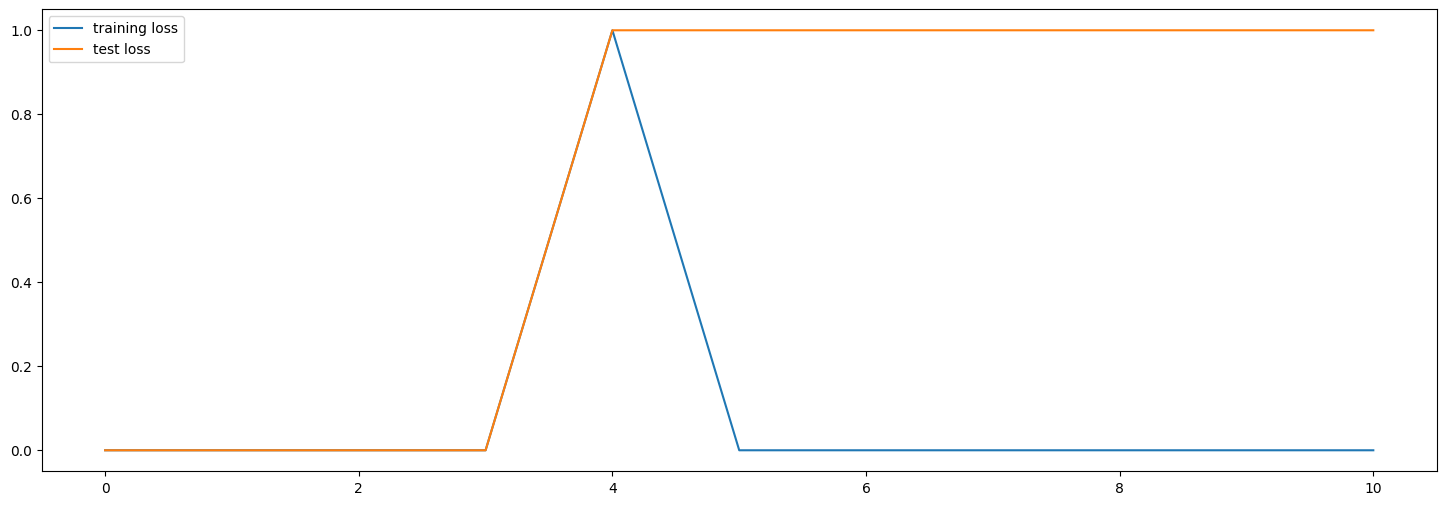

In [63]:
mse, hr_err, hr_err_sq = mod.eval()

print(f'\n\nMSE: {mse}')
print(f'HR error: {hr_err}')
print(f'HR error squared: {hr_err_sq}\n\n')

mod.get_model_stats()
mod.plot_loss()

True HR: 74.8051948051948; Pred HR: 58.32911392405064


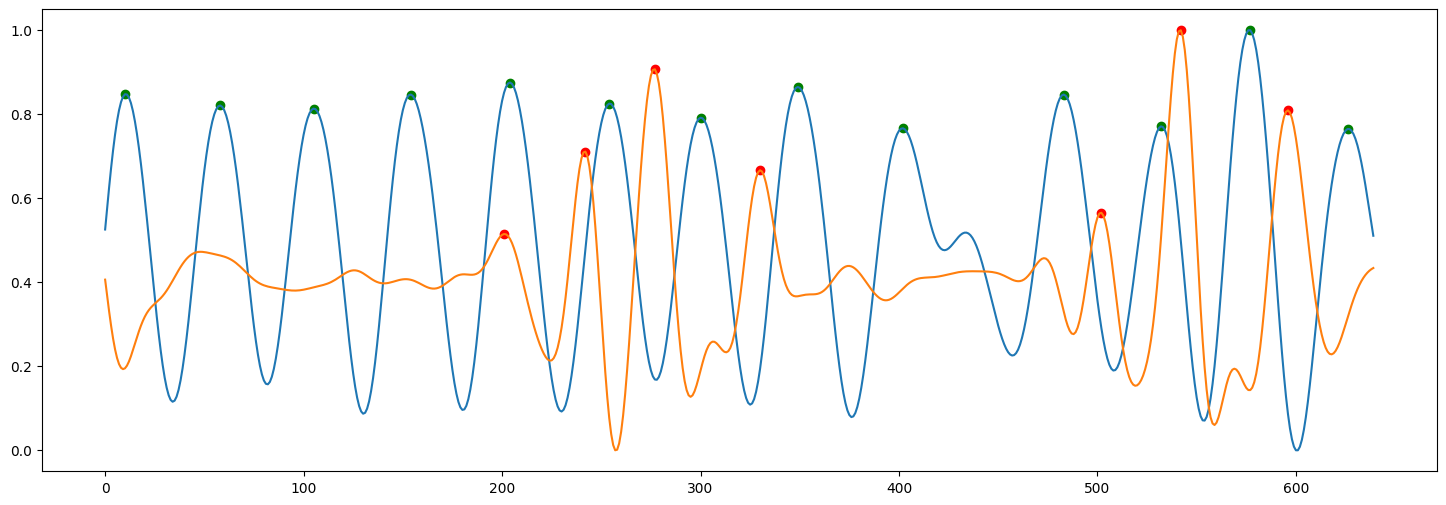

In [48]:
beg = 2000
end = beg + 640

model = mod

data = truths[2].prepare_data_for_ml()
x = data.drop(columns = ['bvp']).to_numpy()
y = data['bvp'].to_numpy()

targ = y[beg: end]
pred = model.predict(x)[beg: end]
targ, pred = mod.process_signal(targ, pred, use_bandpass=True)

pred_peaks, _ = mod.get_predicted_peaks(pred)
true_peaks, _ = mod.get_true_peaks(targ)

plt.plot(targ)
plt.plot(pred)
plt.scatter(pred_peaks, pred[pred_peaks], c='r')
plt.scatter(true_peaks, targ[true_peaks], c='g')

pred_ibis = np.diff(pred_peaks) / 64
true_ibis = np.diff(true_peaks) / 64
pred_hr = get_hr(pred_ibis)
true_hr = get_hr(true_ibis)
print(f'True HR: {true_hr}; Pred HR: {pred_hr}')